# The purpose of this script is to investigate ARIMA approaches for forecasting sales volume
Since I am running this script on my laptop, computing resources are an issue. Thus, my current model only predicts the next 20 days of sales for department 3 of all stores.  
I use a simple SARIMA model (the next step is to incorporate exogenous variables i.e. SARIMAX).  
Below are the WMAEs of my model and a model of all zeros (which is used as a benchmark in the Kaggle competition):  
WMAE = 3621
WMAE all zeros = 17460.56 (benchmark)



## To Do:    
1) Incorporate additional features (besides past sales data) into a SARIMAX model for forecasting sales of department 3  
2) Split up holiday data somehow... maybe say is a given holiday an outlier from the mean of the data  
3) Define a Naive forecast --> Kaggle does all zeros.  
4) See if temperature has anything to do with seasonal sales. Maybe CPI, Gas price and Unemployment have something to do with the magnitude of sales rather than the seasonality of sales.  
5) Investigate creating different models for each store size (A,B,C)  

# Ref:  
How to use auto_arima: https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd  
Forecasting Principles and Practice: https://otexts.com/fpp3/  
Supress Warnings: https://stackoverflow.com/questions/34444607/how-to-ignore-statsmodels-maximum-likelihood-convergence-warning  

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima, ADFTest
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import time
import warnings
import datetime

plt.rcParams["figure.figsize"] = (20,10)
sns.set_style("darkgrid")

Type groups based on store size. Stores with a larger size will have a larger MAE. Should we define different models for each store size (A,B,C)   
All of the dates are friday --> Weekly sales are from Saturday to Friday

In [2]:
features_raw = pd.read_csv("features.csv")
features_raw["Date"] = pd.to_datetime(features_raw["Date"])
train_raw = pd.read_csv("train.csv")
test_raw = pd.read_csv("test.csv")
stores_raw = pd.read_csv("stores.csv")

In [3]:
#### features and train data has same min date. Won't present problems during merging
print(min(features_raw.Date))
print(min(train_raw.Date))

2010-02-05 00:00:00
2010-02-05


## Combine training data

In [90]:
df_train = pd.merge(train_raw, stores_raw, left_on="Store", right_on="Store")
df_train.drop("IsHoliday", inplace=True, axis=1) # features_raw also has IsHoliday
df_train.Date = pd.to_datetime(df_train.Date)
df_train = pd.merge(df_train, features_raw, left_on=["Store", "Date"], right_on=["Store", "Date"])

#### Define the weighted mean calculation

In [11]:
#### Inputs are arrays
def wmae(weights, y, y_hat):
    return sum(weights*np.abs(y-y_hat))/sum(weights)

# Investigate Seasonality
## Look one store/department at a time to get an idea of the data
Holday weeks:
Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13  
Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13  
Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13  
Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13  

Week before Christmas: 12/24/10, 12/23/11  

Thanksgiving causes spikes that don't seem to be related to trend.  

Seems like all we need is a (1,0,0,52) to captuare the seasonality yearly trend.  

Store 1, Department 3: The slope of decline is good. But, the slope of increase does not start early enough... is there a way to shift the slope of incline back one day, while keeping the slope of decline the same?

C:\Users\ahawk\Anaconda3\envs\csci349\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\ahawk\Anaconda3\envs\csci349\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


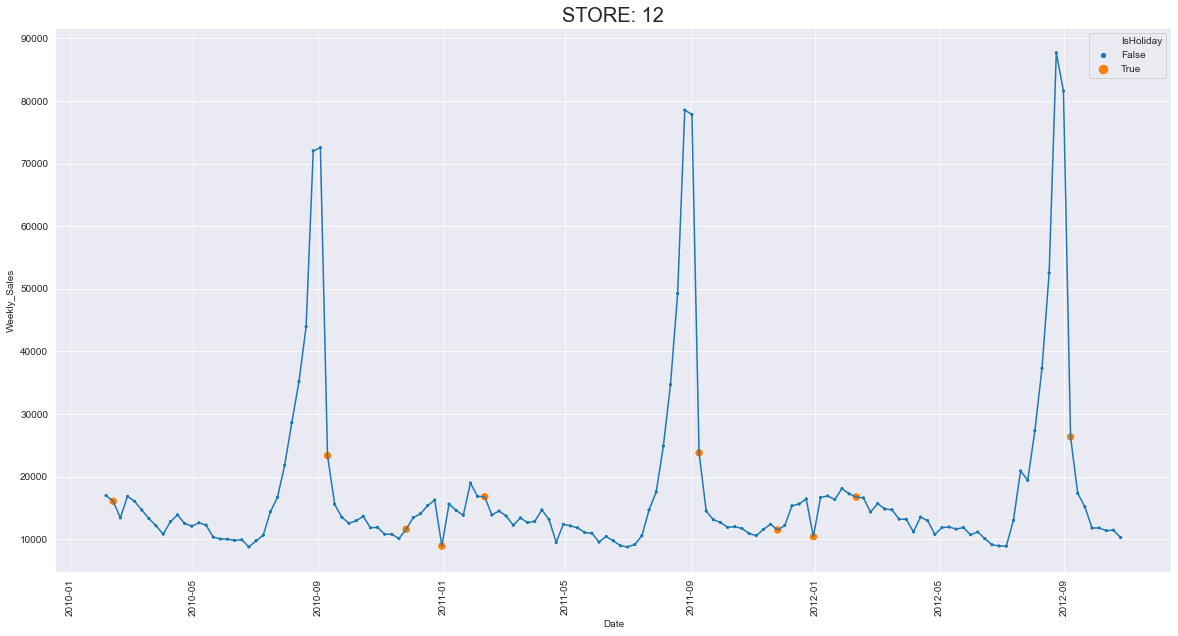

In [185]:
#### Define dataframe for given store
store_num = 12
department_num = 3
df_plot = df_train[df_train.Store == store_num]
df_plot["Date"] = pd.to_datetime(df_plot["Date"])
df_plot.set_index("Date", inplace=True, drop=True)
# df_plot = df_plot.groupby(df_plot.index)[["Weekly_Sales"]].agg("sum")
df_plot = df_plot[df_plot.Dept == department_num][["Weekly_Sales"]]

##### Add holiday data
cur_store_features = features_raw[features_raw.Store == store_num][["Date", "IsHoliday"]].copy()
cur_store_features.set_index("Date", drop=True, inplace=True)
df_plot = pd.merge(df_plot, cur_store_features, left_index=True, right_index=True)

fig, axs = plt.subplots(1,1)

sns.lineplot(data=df_plot, x=df_plot.index, y="Weekly_Sales", ax=axs)
sns.scatterplot(data=df_plot, x=df_plot.index, y="Weekly_Sales", hue="IsHoliday", size="IsHoliday", size_order=[True,False],ax=axs)
plt.xticks(rotation=90)
# for n, label in enumerate(axs.xaxis.get_ticklabels()):
#     if n % 4 != 0:
#         label.set_visible(False)
axs.set_title("STORE: {}".format(store_num), size=20)
fig.show()

In [13]:
test = df_plot[["Weekly_Sales"]].iloc[-20:]
train = df_plot[["Weekly_Sales"]].iloc[:-20]
test_weights = df_plot[["IsHoliday"]].iloc[-20:]
test_weights = [5 if(week) else 1 for week in test_weights["IsHoliday"]]

(0.01, False)


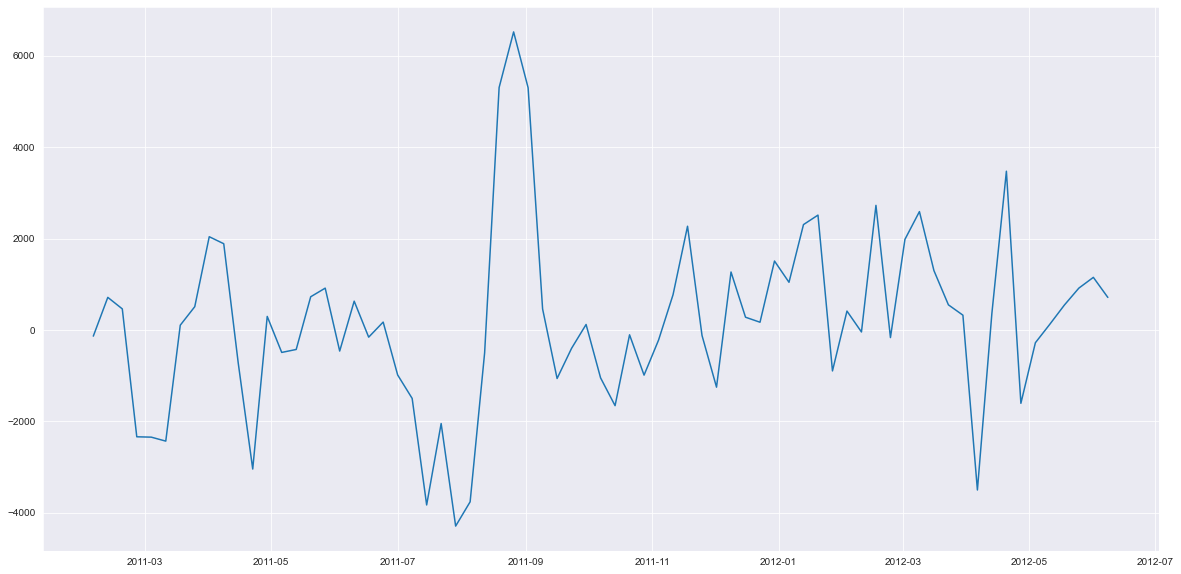

In [15]:
#### Plot seasonality difference & check for stationarity. If less <0.05 (False), then the data is non-stationary
adf_test = ADFTest(alpha = 0.05)
print(adf_test.should_diff(train.diff(52).iloc[52:]))
plt.plot(train.diff(52).iloc[52:]) 

(0.01, False)


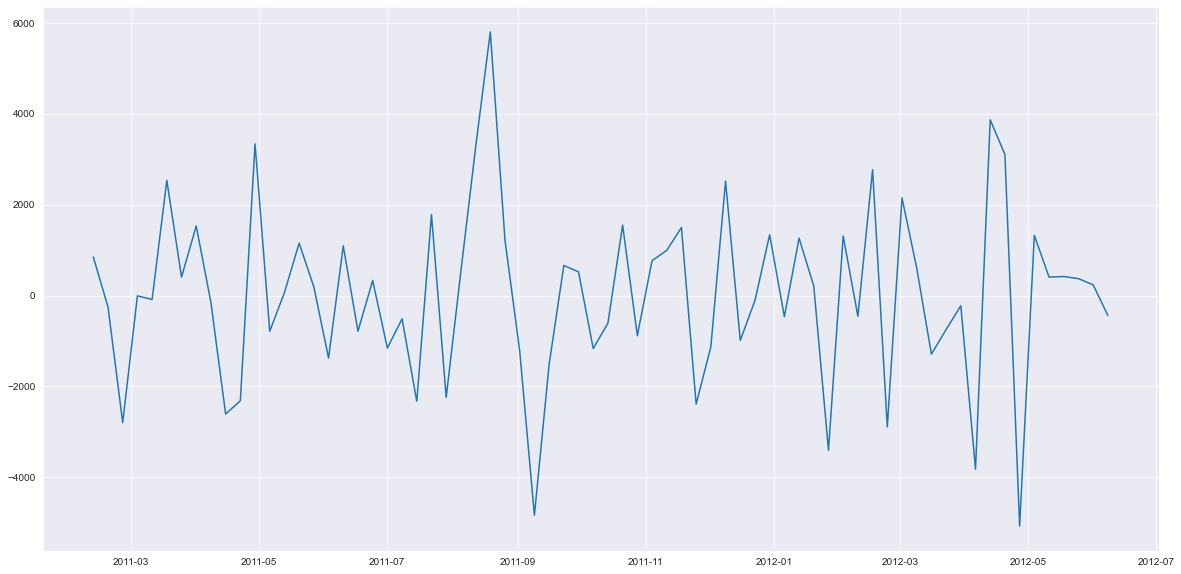

In [17]:
#### Plot seasonally difference plus first difference
adf_test = ADFTest(alpha = 0.05)
print(adf_test.should_diff(train.diff(52).iloc[52:].diff(1).iloc[1:]))
plt.plot(train.diff(52).iloc[52:].diff(1).iloc[1:]) 

In [20]:
# # Check seasonality
# res = seasonal_decompose(train)
# res.plot()
# plt.show()

auto_arima without differencing  

Store 12, Department 3:  
Best model:  ARIMA(4,0,1)(1,0,1)[52] intercept  
Total fit time: 500.439 seconds

In [56]:
# # auto_arima(train, seasonal=True, d=1, start_p=1, start_q=1, max_p=7, max_q=7, max_P=7, max_Q=7, start_P=1, start_Q=1, n_fits=50, trace=True, random=True, m=12, n_jobs=-1)
auto_arima(train, seasonal=True, max_D=1, max_d=1, start_p=3, start_q=3, max_p=7, max_q=7, n_fits=2, trace=True, random=True, n_jobs=-1, m=52)

C:\Users\ahawk\Anaconda3\envs\csci349\lib\site-packages\pmdarima\arima\_validation.py:77: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)


Performing stepwise search to minimize aic
 ARIMA(3,0,3)(1,0,1)[52] intercept   : AIC=2365.410, Time=10.00 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=2384.256, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=2372.018, Time=0.99 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=inf, Time=3.41 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=2564.530, Time=0.02 sec
 ARIMA(3,0,3)(0,0,1)[52] intercept   : AIC=2367.149, Time=7.72 sec
 ARIMA(3,0,3)(1,0,0)[52] intercept   : AIC=2363.361, Time=7.92 sec
 ARIMA(3,0,3)(0,0,0)[52] intercept   : AIC=2389.517, Time=0.83 sec
 ARIMA(3,0,3)(2,0,0)[52] intercept   : AIC=2365.411, Time=36.69 sec
 ARIMA(3,0,3)(2,0,1)[52] intercept   : AIC=inf, Time=43.02 sec
 ARIMA(2,0,3)(1,0,0)[52] intercept   : AIC=inf, Time=7.21 sec
 ARIMA(3,0,2)(1,0,0)[52] intercept   : AIC=2354.114, Time=7.34 sec
 ARIMA(3,0,2)(0,0,0)[52] intercept   : AIC=2389.563, Time=0.34 sec
 ARIMA(3,0,2)(2,0,0)[52] intercept   : AIC=2361.566, Time=35.85 sec
 ARIMA(3,0,2)(1,0,1)[52] inter

ARIMA(order=(4, 0, 1), scoring_args={}, seasonal_order=(1, 0, 1, 52),
      suppress_warnings=True)

auto_arima with differencing  

Store 12, Department 3    
Best model:  ARIMA(0,1,3)(2,1,0)[52]          
Total fit time: 1189.158 seconds

In [57]:
# # auto_arima(train, seasonal=True, d=1, start_p=1, start_q=1, max_p=7, max_q=7, max_P=7, max_Q=7, start_P=1, start_Q=1, n_fits=50, trace=True, random=True, m=12, n_jobs=-1)
auto_arima(train, seasonal=True, d=1, D=1, max_D=1, max_d=1, start_p=3, start_q=3, max_p=7, max_q=7, n_fits=2, trace=True, random=True, n_jobs=-1, m=52)

C:\Users\ahawk\Anaconda3\envs\csci349\lib\site-packages\pmdarima\arima\_validation.py:77: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)


Performing stepwise search to minimize aic
 ARIMA(3,1,3)(1,1,1)[52]             : AIC=inf, Time=29.78 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1310.910, Time=0.52 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=1275.043, Time=2.30 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=1253.006, Time=8.19 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=1265.284, Time=0.38 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=1257.070, Time=5.97 sec
 ARIMA(0,1,1)(0,1,2)[52]             : AIC=inf, Time=37.02 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=1253.473, Time=6.78 sec
 ARIMA(0,1,1)(1,1,2)[52]             : AIC=inf, Time=49.68 sec
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=1291.442, Time=9.18 sec
 ARIMA(1,1,1)(0,1,1)[52]             : AIC=1252.611, Time=8.58 sec
 ARIMA(1,1,1)(0,1,0)[52]             : AIC=1262.693, Time=0.66 sec
 ARIMA(1,1,1)(1,1,1)[52]             : AIC=1257.042, Time=7.62 sec
 ARIMA(1,1,1)(0,1,2)[52]             : AIC=inf, Time=42.24 sec
 ARIMA(1,1,1)(1,1,0)[52]           

ARIMA(order=(0, 1, 3), scoring_args={}, seasonal_order=(2, 1, 0, 52),
      suppress_warnings=True, with_intercept=False)

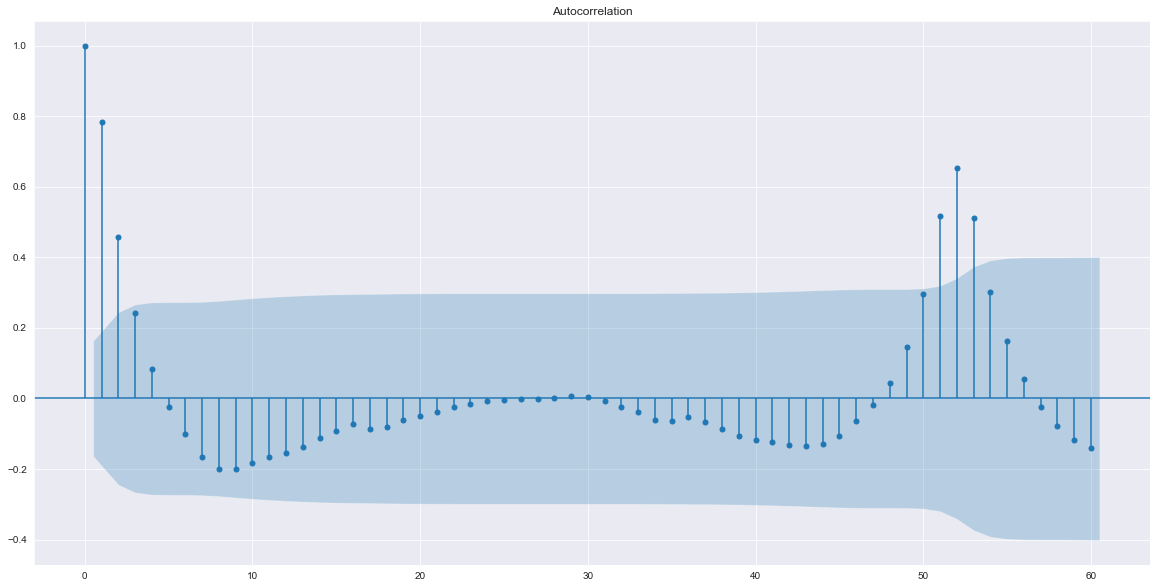

In [21]:
#### ACF Plot
plot_acf(df_plot[["Weekly_Sales"]], lags=60)
plt.show()

C:\Users\ahawk\Anaconda3\envs\csci349\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


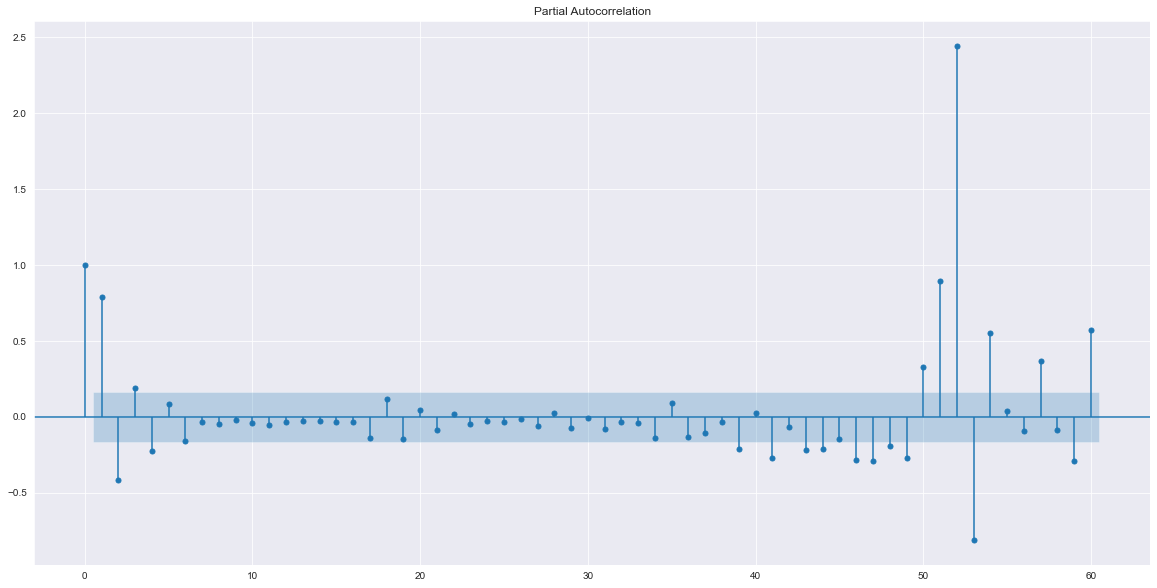

In [56]:
plot_pacf(df_plot[["Weekly_Sales"]], lags=60)
plt.show()

Get model fit results:  

Store 12, Department 3:
order=(0,1,0), seasonal_order=(1,1,0,52) --> Weighted MAE = 1,952
seasonal_order=(2,1,0,52)                --> Weighted MAE = 1,444
order=(0,1,3), seasonal_order=(2,1,0,52) --> Weighted MAE = 1,420 (Best configuration according to auto_arima)
order=(0,1,2), seasonal_order=(2,1,0,52) --> Weighted MAE = 1,374  
order=(0,1,1), seasonal_order=(2,1,0,52) --> Weighted MAE = 1,304
order=(0,1,1), seasonal_order=(2,1,4,52) --> Weighted MAE = 1,303 (Not sure why having a seasonal MA value slightly increases performance)



Store 12, Department 3:  
(0,1,1),(2,1,0,52) gives the same Weighted MAE as (0,1,1),(3,1,0,52). The coefficient of ar.S.L156 = 1.725e-06 ~= 0. This makes sense since we only have 2 years of training data. ar.S.L156 looks for data 3 years in the past, and this data dose not exist which is why the coefficient is basically 0.  
However, adding a MA term does not resulit in ~0 coefficients: (0,1,1),(2,1,4,52) --> ma.S.L156=0.081, ma.S.L208=0.0058



C:\Users\ahawk\Anaconda3\envs\csci349\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
C:\Users\ahawk\Anaconda3\envs\csci349\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
C:\Users\ahawk\Anaconda3\envs\csci349\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


Weighted MAE: 1,304
                                      SARIMAX Results                                      
Dep. Variable:                        Weekly_Sales   No. Observations:                  123
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 52)   Log Likelihood                -626.712
Date:                             Sun, 01 Aug 2021   AIC                           1261.424
Time:                                     23:14:21   BIC                           1270.418
Sample:                                 02-05-2010   HQIC                          1264.996
                                      - 06-08-2012                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2012      0.098     -2.054      0.040      -0.393      -0.009
ar.S.L5

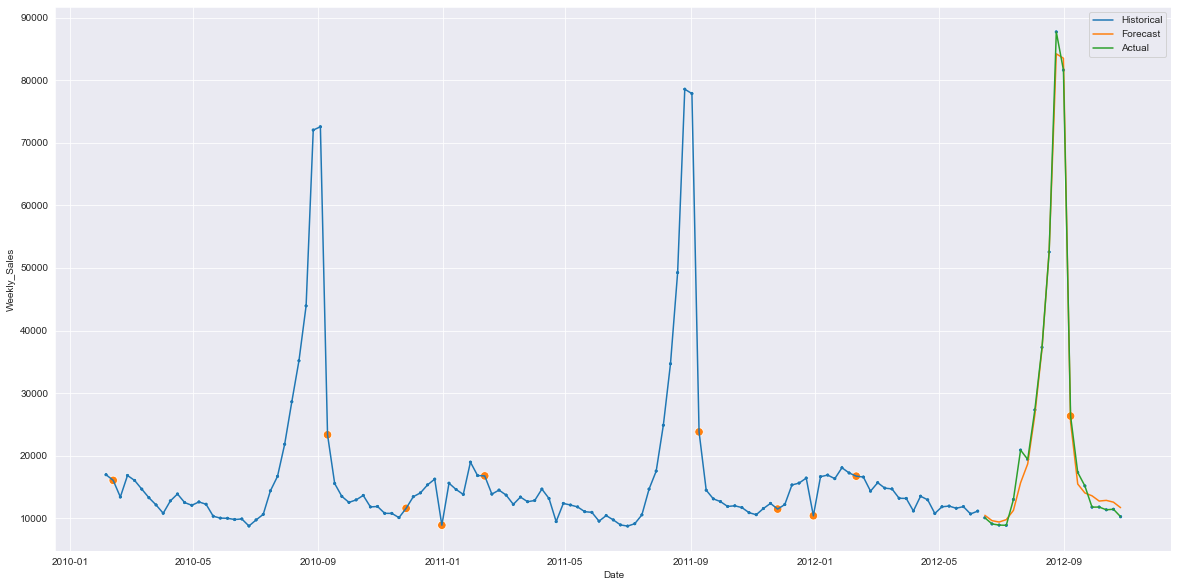

In [52]:
model_fit = SARIMAX(train, order=(0,1,1), seasonal_order=(2,1,0,52)).fit()
forecast = model_fit.predict(len(train), len(train)+len(test)-1)
#### Since we are predicting 20 days, and one of the days is a holiday, the sum of the weights is 24.
print("Weighted MAE: {:,.0f}".format(wmae(test_weights,forecast.values,test["Weekly_Sales"].values)))
print(model_fit.summary())
plt.plot(train)
plt.plot(forecast)
plt.plot(test)
sns.scatterplot(data=df_plot, x=df_plot.index, y="Weekly_Sales", hue="IsHoliday", size="IsHoliday", size_order=[True,False])
plt.legend(["Historical", "Forecast", "Actual"])

# Try running model on department 3 for all stores.
#### The SARIMA model we will use is derived from the above process for store 12

In [175]:
dept=3
df_department_3_forecast = pd.DataFrame(columns=["Store", "Weekly_Sales", "IsHoliday"],index=[])
df_department_3_actuals = pd.DataFrame(columns=["Store", "Weekly_Sales"],index=[])
# for store in df_train.Store.unique():
for store in df_train.Store.unique():
    start_time = time.perf_counter()
    #### Get weekly sales for current store,department
    df_cur_store = df_train[(df_train.Store == store) & (df_train.Dept == dept)]
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        df_cur_store["Date"] = pd.to_datetime(df_cur_store["Date"])
    df_cur_store.set_index("Date", inplace=True, drop=True)
    df_cur_store_sales = df_cur_store[["Weekly_Sales"]].copy()

    #### Split training and testing data
    df_test_store = df_cur_store_sales[["Weekly_Sales"]].iloc[-20:]
    df_train_store = df_cur_store_sales[["Weekly_Sales"]].iloc[:-20]

    #### Run ARIMA model and get forecasted sales 
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        model_fit = SARIMAX(df_train_store, order=(0,1,1), seasonal_order=(2,1,0,52)).fit()
    forecast = model_fit.predict(len(df_train_store), len(df_train_store)+len(df_test_store)-1)

    #### Get weights for test data. Used for calculation of weighted MAE
    test_weights = df_cur_store[["IsHoliday"]].iloc[-20:]
    test_weights = [5 if(week) else 1 for week in test_weights["IsHoliday"]]
    
    #### Get Weighted MAE
    cur_mae = wmae(test_weights,forecast.values,df_test_store["Weekly_Sales"].values)
    cur_mae_zeros = wmae(test_weights,np.zeros(20),df_test_store["Weekly_Sales"].values)
    print("Weighted MAE Store {}: {:,.0f}".format(store, cur_mae))
    print("Weighted MAE All Zeros Store {}: {:,.0f}".format(store, cur_mae_zeros))
    
    #### Define dataframe to hold store historical,forecast data
    df_cur_store_sales_plus_forecast = df_train_store.append(pd.DataFrame(forecast).rename(columns={"predicted_mean":"Weekly_Sales"}))
    #### Add holiday data.
    cur_store_features = features_raw[features_raw.Store == store][["Date", "IsHoliday"]].copy()
    cur_store_features.set_index("Date", drop=True, inplace=True)
    df_cur_store_sales_plus_forecast = pd.merge(df_cur_store_sales_plus_forecast, cur_store_features, left_index=True, right_index=True)
    #### Append current dataframe to full dataframe of historical,prediction
    df_cur_store_sales_plus_forecast["Store"] = [store]*len(df_cur_store_sales_plus_forecast)
    df_department_3_forecast = df_department_3_forecast.append(df_cur_store_sales_plus_forecast)
    
    #### Append actuals to full dataframe of actuals
    df_test_store["Store"] = [store]*len(df_test_store)
    df_department_3_actuals = df_department_3_actuals.append(df_test_store)
    
    print("Time elapsed: {:.1f}".format(time.perf_counter()-start_time))
    
#### Get Total WMAE of forecast and of all zeros
store_forecast = df_department_3_forecast[df_department_3_forecast.index >= datetime.datetime(2012,6,15)].copy()
holiday_weights = [5 if(week) else 1 for week in store_forecast["IsHoliday"]]
total_mae = wmae(holiday_weights, df_department_3_actuals.Weekly_Sales.values, store_forecast.Weekly_Sales.values)
total_mae_zeros = wmae(holiday_weights, df_department_3_actuals.Weekly_Sales.values, np.zeros(len(store_forecast)))
print(total_mae)
print(total_mae_zeros)

Weighted MAE Store 1: 4,478
Weighted MAE All Zeros Store 1: 18,539
Time elapsed: 13.2
Weighted MAE Store 2: 4,914
Weighted MAE All Zeros Store 2: 23,992
Time elapsed: 4.8
Weighted MAE Store 3: 1,586
Weighted MAE All Zeros Store 3: 7,981
Time elapsed: 21.2
Weighted MAE Store 4: 1,864
Weighted MAE All Zeros Store 4: 27,279
Time elapsed: 5.1
Weighted MAE Store 5: 1,233
Weighted MAE All Zeros Store 5: 5,299
Time elapsed: 22.7
Weighted MAE Store 6: 5,265
Weighted MAE All Zeros Store 6: 23,466
Time elapsed: 4.0
Weighted MAE Store 7: 1,247
Weighted MAE All Zeros Store 7: 11,192
Time elapsed: 11.7
Weighted MAE Store 8: 3,905
Weighted MAE All Zeros Store 8: 15,036
Time elapsed: 4.8
Weighted MAE Store 9: 3,672
Weighted MAE All Zeros Store 9: 10,325
Time elapsed: 11.7
Weighted MAE Store 10: 7,984
Weighted MAE All Zeros Store 10: 39,673
Time elapsed: 4.2
Weighted MAE Store 11: 4,279
Weighted MAE All Zeros Store 11: 24,082
Time elapsed: 6.6
Weighted MAE Store 12: 1,304
Weighted MAE All Zeros Store 

#### Plot a given store's department 3 historical, forecast and actual

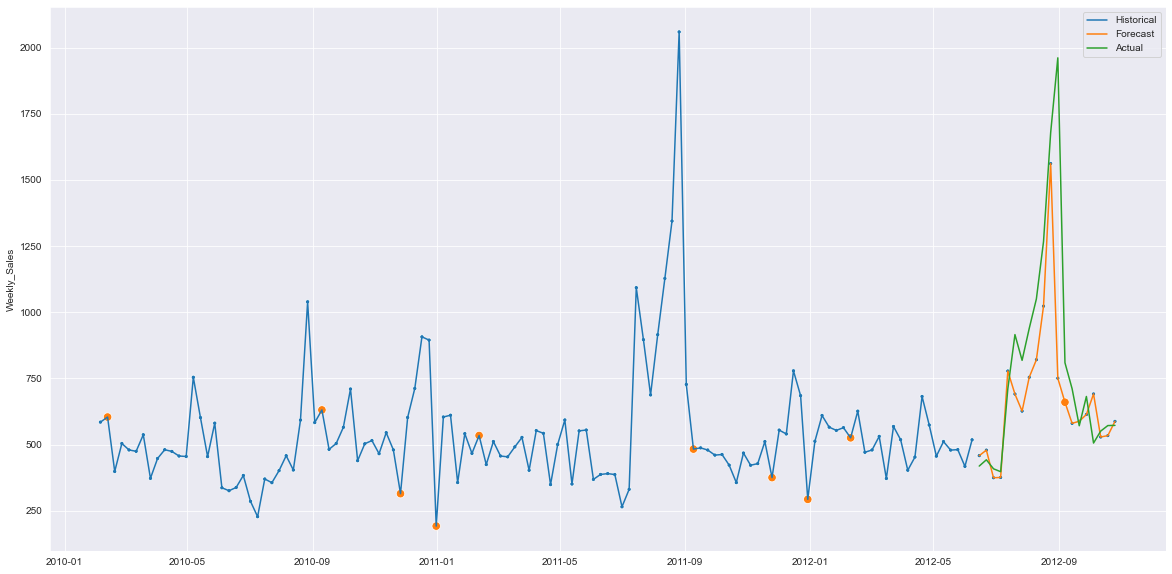

In [189]:
display_store=44
df_store_display = df_department_3_forecast[df_department_3_forecast.Store == display_store].copy()
plt.plot(df_store_display.iloc[:-20][["Weekly_Sales"]])
plt.plot(df_store_display.iloc[-20:][["Weekly_Sales"]])
plt.plot(df_department_3_actuals[df_department_3_actuals.Store == display_store][["Weekly_Sales"]])
sns.scatterplot(data=df_store_display, x=df_store_display.index, y="Weekly_Sales", hue="IsHoliday", size="IsHoliday", size_order=[True,False])
plt.legend(["Historical", "Forecast", "Actual"])
plt.show()

# Investigate Features - WORK IN PROGRESS

In [435]:
#### Below we see that features are different for different states on the same date
features_raw[features_raw.Date == "2010-02-05"].head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
182,2,2010-02-05,40.19,2.572,NaN,NaN,NaN,NaN,NaN,210.752605,8.324,False
364,3,2010-02-05,45.71,2.572,NaN,NaN,NaN,NaN,NaN,214.424881,7.368,False
546,4,2010-02-05,43.76,2.598,NaN,NaN,NaN,NaN,NaN,126.442065,8.623,False
728,5,2010-02-05,39.70,2.572,NaN,NaN,NaN,NaN,NaN,211.653972,6.566,False


In [442]:
#### Below we see temperature, fuel_price, and CPI change weekly. Unemployment changes quarterly
features_raw[features_raw.Store == 1].head(30)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
5,1,2010-03-12,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,False
6,1,2010-03-19,54.58,2.720,NaN,NaN,NaN,NaN,NaN,211.215635,8.106,False
7,1,2010-03-26,51.45,2.732,NaN,NaN,NaN,NaN,NaN,211.018042,8.106,False
8,1,2010-04-02,62.27,2.719,NaN,NaN,NaN,NaN,NaN,210.820450,7.808,False
9,1,2010-04-09,65.86,2.770,NaN,NaN,NaN,NaN,NaN,210.622857,7.808,False


C:\Users\ahawk\Anaconda3\envs\csci349\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


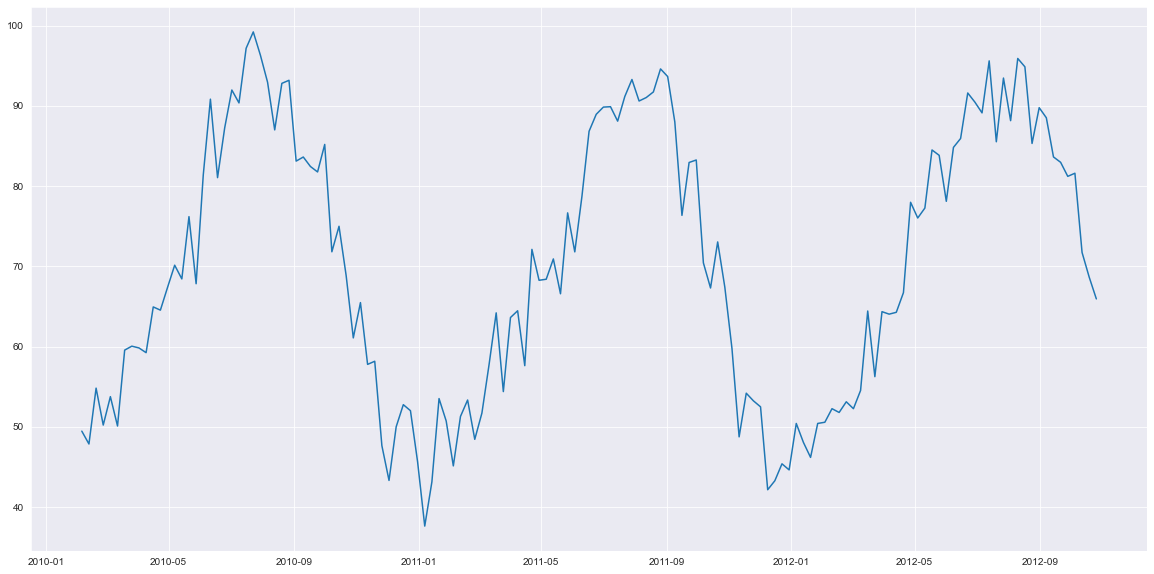

In [457]:
#### Define dataframe for given store
df_plot = df_train[df_train.Store == store_num]
df_plot["Date"] = pd.to_datetime(df_plot["Date"])
df_plot.set_index("Date", inplace=True, drop=True)
df_plot = df_plot[df_plot.Dept == department_num]
# plt.plot(df_plot[["Temperature", "Fuel_Price"]]) # NEED TO NORMALIZE WHEN COMPARING PLOTS ON SAME AXIS. REMEMBER, ZERO STAYS ZERO!!!
plt.plot(df_plot["Temperature"])